In [482]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier

In [483]:
#merging for BDT training
node_6=pd.read_hdf("node_6.hd5")
node_9=pd.read_hdf("node_9.hd5")
node_4=pd.read_hdf("node_4.hd5")
node_SM=pd.read_hdf("node_SM.hd5")

frames=[node_6,node_9,node_4,node_SM]
df=pd.concat(frames)

#indexing
random_index = np.arange(df.shape[0]) 
np.random.shuffle(random_index)
df["random_index"]=random_index 
df.set_index("random_index",inplace=True)
df.sort_index(inplace=True)

In [484]:
df.columns

Index([u'candidate_id', u'weight', u'mgg', u'mbb', u'leadPho_px',
       u'leadPho_py', u'leadPho_pz', u'leadPho_e', u'subleadPho_px',
       u'subleadPho_py', u'subleadPho_pz', u'subleadPho_e', u'leadJet_px',
       u'leadJet_py', u'leadJet_pz', u'leadJet_e', u'subleadJet_px',
       u'subleadJet_py', u'subleadJet_pz', u'subleadJet_e', u'rho', u'nvtx',
       u'event', u'lumi', u'processIndex', u'run', u'npu', u'puweight', u'cat',
       u'bdtcat', u'mxcat', u'leadPho_pt', u'leadPho_eta', u'leadPho_phi',
       u'leadPho_m', u'subleadPho_pt', u'subleadPho_eta', u'subleadPho_phi',
       u'subleadPho_m', u'leadJet_pt', u'leadJet_eta', u'leadJet_phi',
       u'leadJet_m', u'subleadJet_pt', u'subleadJet_eta', u'subleadJet_phi',
       u'subleadJet_m', u'hgg_px', u'hgg_py', u'hgg_pz', u'hgg_e', u'hgg_pt',
       u'hgg_eta', u'hgg_phi', u'hgg_m', u'hbb_px', u'hbb_py', u'hbb_pz',
       u'hbb_e', u'hbb_pt', u'hbb_eta', u'hbb_phi', u'hbb_m', u'hh_px',
       u'hh_py', u'hh_pz', u'hh_e', u'hh

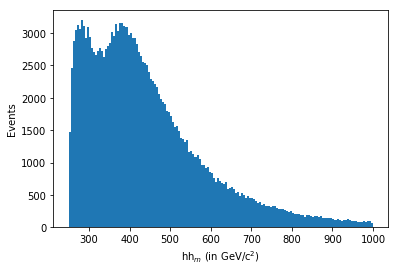

In [485]:
plt.hist(df['hh_m'],range=[250,1000],bins=150)
plt.ylabel("Events")
plt.xlabel("hh$_m$ (in GeV/c$^2$)")
plt.show()

In [486]:
features = ['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg']
features+=['leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta']
features+=['leadPho_pt','leadPho_eta','subleadPho_pt','subleadPho_eta']

In [487]:
#finding sum, count, mean of each category in weights column
df.groupby('cat')['weight'].agg(['sum','count','mean'])

,sum,count,mean
cat,,,
0,2.971749,148936,0.000020
1,0.159532,8433,0.000019
2,0.152647,8202,0.000019
3,0.051188,2788,0.000018
4,0.013646,750,0.000018
5,0.030381,1523,0.000020
6,0.054648,2868,0.000019
7,0.041555,2245,0.000019
8,0.019401,1077,0.000018


In [488]:
X = df[features]
y = df['cat'] 
w = df['weight'] 

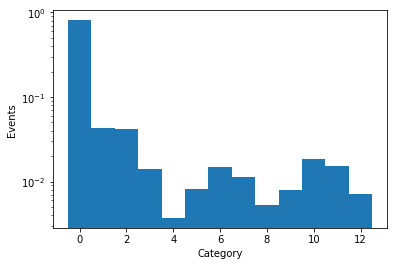

In [489]:
#plotting truth histogram (weighted histogram of categories with logarithmic y scale)
plt.hist(y,weights=w,bins=13,range=[-0.5,12.5],normed='True')
plt.xlabel('Category')
plt.ylabel('Events')
plt.yscale('log')
plt.show()

In [490]:
#slicing data randomly into training and testing sets- we take 20% to be the training set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

In [491]:
#classifier fitted to training set 
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)

CPU times: user 3min 43s, sys: 5.55 s, total: 3min 49s
Wall time: 28.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [492]:
#predicting probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
#predicting weight of each data in test set according to category 
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)

In [493]:
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

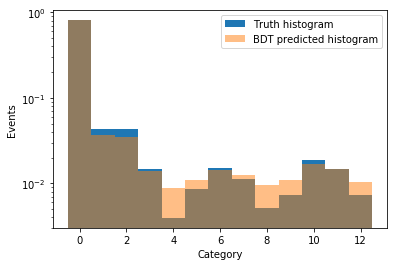

In [494]:
#plotting truth histogram and BDT predicted histogram
plt.hist(y_test,weights=w_test,bins=13,range=[-0.5,12.5],normed='True',label='Truth histogram')
plt.hist(y_pred.ravel(),weights=y_pred_weight.ravel(),bins=13,range=[-0.5,12.5],normed='True',alpha=0.5,label='BDT predicted histogram')
plt.legend()
plt.xlabel('Category')
plt.ylabel('Events')
plt.yscale('log')
plt.show()

In [495]:
#reweighting according to 1/h, and clipping it at 50
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5],normed='True')
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,10)
w_train*=rw[y_train]

In [496]:
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)

CPU times: user 3min 49s, sys: 4.85 s, total: 3min 54s
Wall time: 29.4 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [497]:
#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)/rw.reshape(1,-1)
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category 
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

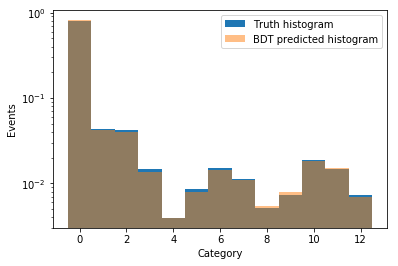

In [498]:
#plotting truth histogram and BDT predicted histogram
plt.hist(y_test,weights=w_test,bins=13,range=[-0.5,12.5],normed='True',label='Truth histogram')
plt.hist(y_pred.ravel(),weights=y_pred_weight.ravel(),bins=13,range=[-0.5,12.5],normed='True',alpha=0.5,label='BDT predicted histogram')
plt.legend()
plt.xlabel('Category')
plt.ylabel('Events')
plt.yscale('log')
plt.show()

In [499]:
#xgboost.plot_importance(clf.get_booster(),importance_type='weight',height=0.3,max_num_features=25)